# 금융 CSS(신용평가모델) 개발 prepro&test(LJE)

## 1. 데이터 불러오기

In [2]:
# 라이브러리 가져오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

C:\Users\LG\AppData\Local\Temp\ipykernel_7936\2478983249.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
train_df = pd.read_csv('css/train.csv')
test_df = pd.read_csv('css/test.csv')

display(train_df.head(3))
display(test_df.head(3))

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A


,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,TEST_00000,16800000,36 months,8 years,MORTGAGE,132000000,19.64,12,주택 개선,0,394692,146604.0,0.0,0.0
1,TEST_00001,8400000,36 months,5 years,RENT,89971200,15.84,25,부채 통합,0,0,0.0,0.0,0.0
2,TEST_00002,17280000,36 months,6 years,RENT,150000000,8.41,20,신용 카드,0,1786980,281820.0,0.0,0.0


## 2. 데이터 전처리

### (1) 데이터 바꾸기

In [4]:
# 대출기간 전처리 (int로 바꾸기)
def get_loan_month(mt):
    return int(mt.strip().replace('months', ''))

train_df['대출기간'] = train_df['대출기간'].apply(get_loan_month)
train_df[['대출기간']]

,대출기간
0,36
1,60
2,36
3,36
4,60
...,...
96289,36
96290,60
96291,36
96292,36


In [5]:
# 근로기간 전처리 (0, 1, 2, ..., 10 (int), unknown은 nan 대체)
def get_work_year(yr):
    if yr in ['<1 year', '< 1 year']:
        return 0
    elif yr in ['1 year', '1 years']:
        return 1
    elif yr in ['10+ years', '10+years']:
        return 10
    # 'Unknown'은 NaN으로 대체
    elif yr == 'Unknown':
        return np.nan
    # 그 외는 숫자만 추출
    else:
        return int(''.join(filter(str.isdigit, yr)))

train_df['근로기간'] = train_df['근로기간'].apply(get_work_year)
train_df[['근로기간']]

,근로기간
0,6.0
1,10.0
2,5.0
3,8.0
4,NaN
...,...
96289,10.0
96290,10.0
96291,1.0
96292,5.0


### (2) 데이터 삭제하기

In [6]:
# ID 컬럼 drop
train_df = train_df.drop(labels='ID', axis=1)

In [7]:
# 부채_대비_소득_비율 9999 drop
train_df = train_df.drop(train_df[train_df['부채_대비_소득_비율']==9999].index)

### (3) 데이터 컬럼 추가하기

In [8]:
def get_plus_col(df):
    df['상환부담율'] = df['총상환이자'] / df['대출금액']
    df['상환율'] = df['총상환원금'] / df['대출금액']
    df['대출_대비_총상환금_비율'] = (df['총상환원금'] + df['총상환이자']) / df['대출금액']
    df['잔여상환금_대비_연체금액_비율'] = df['총연체금액'] / (df['대출금액'] - df['총상환원금'])
    df['연체계좌비율'] = df['연체계좌수'] / df['총계좌수']

get_plus_col(train_df)
train_df.head(3)

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,상환부담율,상환율,대출_대비_총상환금_비율,잔여상환금_대비_연체금액_비율,연체계좌비율
0,12480000,36,6.0,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C,0.000000,0.000000,0.000000,0.0,0.0
1,14400000,60,10.0,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B,0.016254,0.025943,0.042197,0.0,0.0
2,12000000,36,5.0,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A,0.012662,0.077387,0.090049,0.0,0.0


### (4) 주택소유 여부 (함수 인코딩)

In [9]:
# 주택소유여부
def get_home(chr):
    if chr in ['MORTGAGE', 'RENT', 'ANY']:
        return 0
    else:
        return 1

train_df['주택소유여부'] = train_df['주택소유상태'].apply(get_home)
train_df[['주택소유여부']]

,주택소유여부
0,0
1,0
2,0
3,0
4,0
...,...
96289,0
96290,0
96291,0
96292,0


In [10]:
# 한글 깨짐 해결
# 출처: https://giveme-happyending.tistory.com/168 [소연의_개발일지:티스토리]
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

## 3. EDA

In [11]:
train_df3 = train_df.copy()

- 대출등급 A~G => 6~0 으로 전처리

In [12]:
def get_grade_to_num(x):
    if x == 'A': return 6
    if x == 'B': return 5
    if x == 'C': return 4
    if x == 'D': return 3
    if x == 'E': return 2
    if x == 'F': return 1
    if x == 'G': return 0

train_df3['대출등급'] = train_df3['대출등급'].apply(get_grade_to_num)
train_df3.head(3)

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,상환부담율,상환율,대출_대비_총상환금_비율,잔여상환금_대비_연체금액_비율,연체계좌비율,주택소유여부
0,12480000,36,6.0,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,4,0.000000,0.000000,0.000000,0.0,0.0,0
1,14400000,60,10.0,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,5,0.016254,0.025943,0.042197,0.0,0.0,0
2,12000000,36,5.0,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,6,0.012662,0.077387,0.090049,0.0,0.0,0


- 대출등급 분포 살펴보기

C:\Users\LG\AppData\Local\Temp\ipykernel_7936\1051208842.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(train_df3, x='대출등급',order=x_label_order ,palette='Set3').set_title('대출등급 분포')


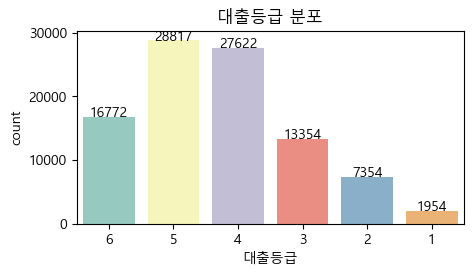

In [13]:
fig, ax = plt.subplots(figsize=(5,2.5))

x_label_order = [6,5,4,3,2,1]
sns.countplot(train_df3, x='대출등급',order=x_label_order ,palette='Set3').set_title('대출등급 분포')

for p in ax.patches:
    ax.text(p.get_x() + (p.get_width()/2), # 가로 위치
            p.get_y() + p.get_height(),  # 세로 위치
            f"{p.get_height():.0f}",  # 값 + 표시방법(소수 둘째자리까지)
            ha = 'center')  # 좌우 정렬 중간으로
    

- 대출등급 별 범주형 데이터 분포 살펴보기

범주형 데이터 : 대출기간, 근로기간, 주택소유상태, 대출목적

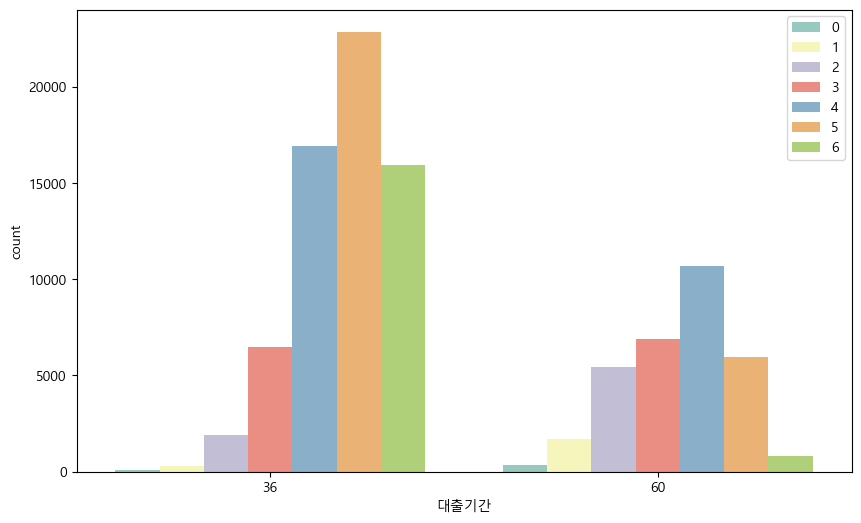

36
대출등급
5    22883
4    16934
6    15952
3     6485
2     1895
1      270
0       59
Name: count, dtype: int64

60
대출등급
4    10688
3     6869
5     5934
2     5459
1     1684
6      820
0      361
Name: count, dtype: int64



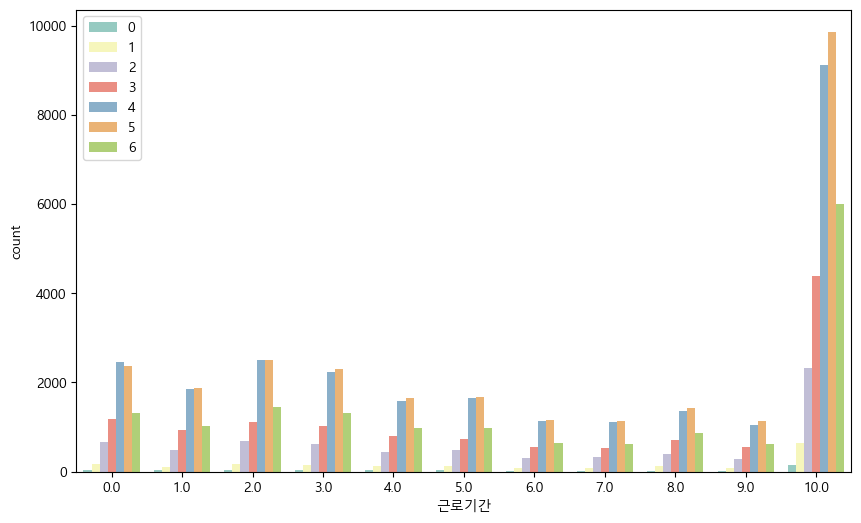

6.0
대출등급
5    1157
4    1124
6     650
3     543
2     296
1      85
0      19
Name: count, dtype: int64

10.0
대출등급
5    9865
4    9105
6    6009
3    4385
2    2331
1     649
0     137
Name: count, dtype: int64

5.0
대출등급
5    1679
4    1646
6     986
3     736
2     475
1     119
0      24
Name: count, dtype: int64

8.0
대출등급
5    1417
4    1364
6     867
3     707
2     385
1     128
0      20
Name: count, dtype: int64

nan
Series([], Name: count, dtype: int64)

9.0
대출등급
5    1137
4    1049
6     621
3     545
2     289
1      85
0      18
Name: count, dtype: int64

2.0
대출등급
4    2495
5    2493
6    1454
3    1107
2     695
1     170
0      36
Name: count, dtype: int64

1.0
대출등급
5    1867
4    1860
6    1031
3     927
2     481
1     110
0      29
Name: count, dtype: int64

3.0
대출등급
5    2302
4    2225
6    1315
3    1028
2     608
1     153
0      39
Name: count, dtype: int64

7.0
대출등급
5    1138
4    1103
6     619
3     535
2     318
1      79
0      22
Name: count, dtype: int64

4.

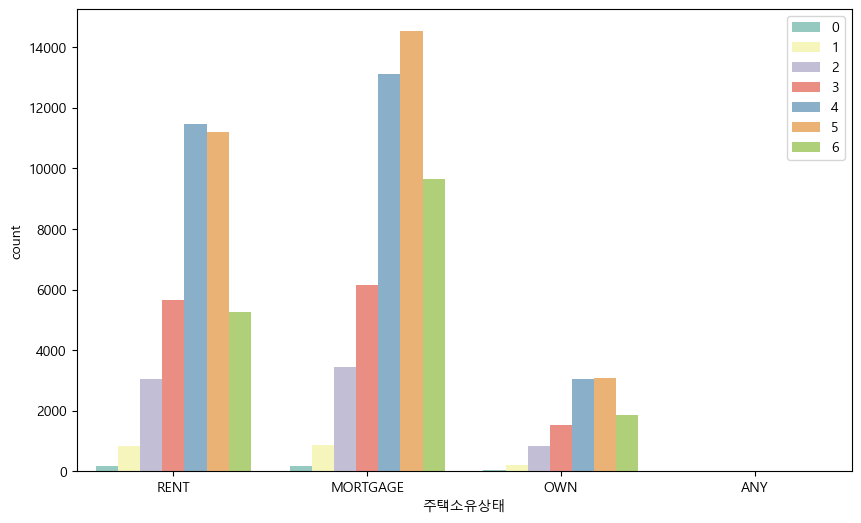

RENT
대출등급
4    11478
5    11200
3     5653
6     5268
2     3056
1      855
0      195
Name: count, dtype: int64

MORTGAGE
대출등급
5    14518
4    13105
6     9640
3     6163
2     3452
1      883
0      172
Name: count, dtype: int64

OWN
대출등급
5    3099
4    3038
6    1864
3    1538
2     846
1     216
0      53
Name: count, dtype: int64

ANY
대출등급
4    1
Name: count, dtype: int64



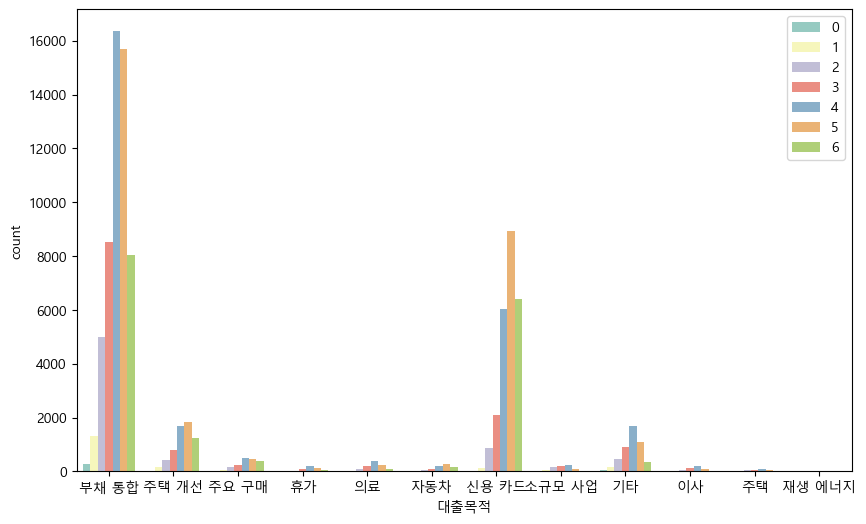

부채 통합
대출등급
4    16349
5    15680
3     8529
6     8036
2     4979
1     1311
0      266
Name: count, dtype: int64

주택 개선
대출등급
5    1845
4    1689
6    1225
3     805
2     425
1     145
0      26
Name: count, dtype: int64

주요 구매
대출등급
4    503
5    479
6    372
3    238
2    150
1     53
0      8
Name: count, dtype: int64

휴가
대출등급
4    196
5    119
3     78
6     40
2     27
1      4
0      2
Name: count, dtype: int64

의료
대출등급
4    375
5    238
3    197
6    104
2     91
1     27
0      7
Name: count, dtype: int64

자동차
대출등급
5    258
4    213
6    174
3     87
2     46
1     15
0      4
Name: count, dtype: int64

신용 카드
대출등급
5    8917
6    6424
4    6035
3    2092
2     877
1     137
0      17
Name: count, dtype: int64

소규모 사업
대출등급
4    249
3    192
2    158
5     75
1     64
0     30
6     19
Name: count, dtype: int64

기타
대출등급
4    1705
5    1080
3     916
2     478
6     356
1     147
0      43
Name: count, dtype: int64

이사
대출등급
4    203
3    131
5     86
2     50
1     18
6     13
0   

In [14]:
ctgr_list = ['대출기간', '근로기간', '주택소유상태', '대출목적']

def ctgr_value_counts(iumn_name):
    for uniq in list(train_df3[iumn_name].unique()):
        cond_unique = (train_df3[iumn_name]==uniq)
        print(uniq)
        print(train_df3.loc[cond_unique]['대출등급'].value_counts())
        print()

for i in ctgr_list:
    plt.figure(figsize=(10,6))
    sns.countplot(data=train_df3, x=i, hue='대출등급', palette='Set3')     
    plt.legend(loc='best')
    plt.show()
    ctgr_value_counts(iumn_name=i)

수치형 데이터 : 대출금액, 연간소득, 부채_대비_소득_비율, 총계좌수, 최근_2년간_연체_횟수, 총상환금, 총상환이자, 총연체금액, 연체계좌수

C:\Users\LG\AppData\Local\Temp\ipykernel_7936\2029728365.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df3, y=col, x='대출등급', order=hue_order, ax=ax[1], palette='Set3')


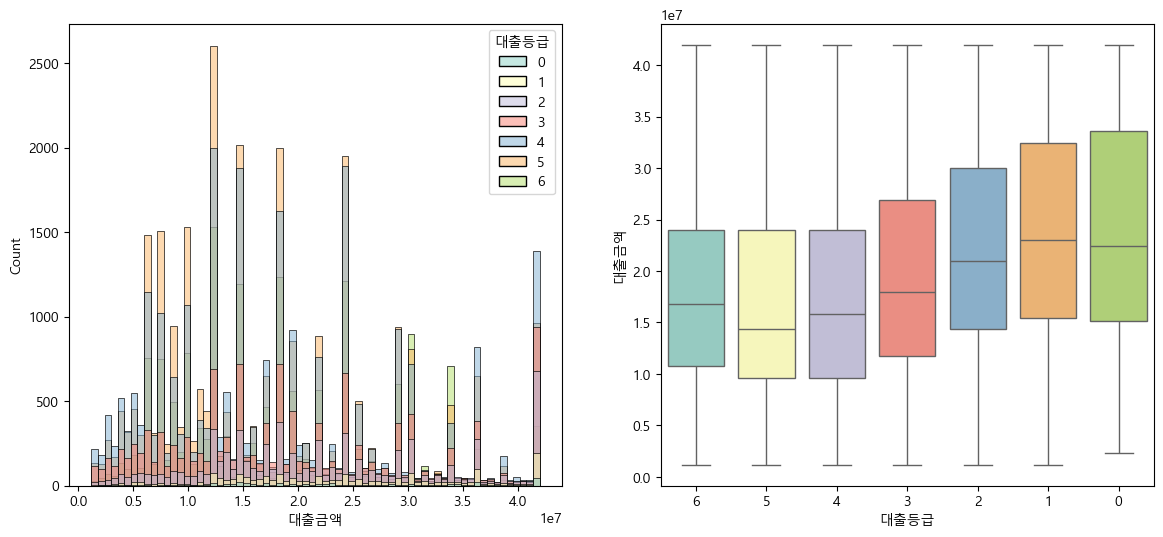

,mean,std,min,max
6,1.790579e+07,9.294000e+06,1200000.0,42000000.0
5,1.686808e+07,9.772310e+06,1200000.0,42000000.0
4,1.789053e+07,1.052497e+07,1200000.0,42000000.0
3,1.953331e+07,1.097276e+07,1200000.0,42000000.0
2,2.232013e+07,1.077465e+07,1200000.0,42000000.0
1,2.400517e+07,1.061245e+07,1200000.0,42000000.0
0,2.402079e+07,1.080393e+07,2310000.0,42000000.0


C:\Users\LG\AppData\Local\Temp\ipykernel_7936\2029728365.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df3, y=col, x='대출등급', order=hue_order, ax=ax[1], palette='Set3')


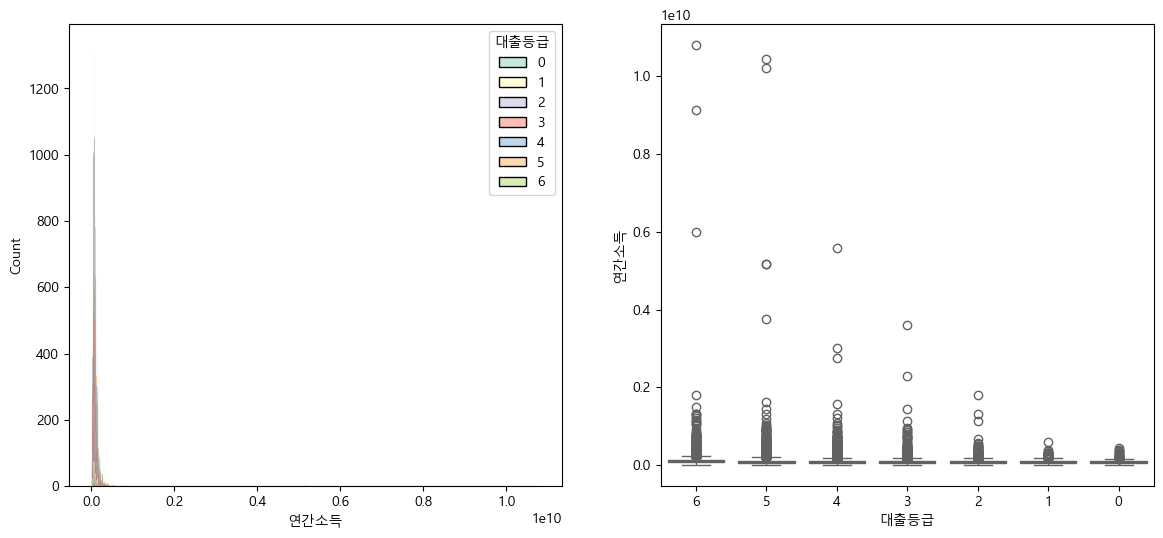

,mean,std,min,max
6,1.124911e+08,1.396115e+08,11424000.0,1.080000e+10
5,9.570640e+07,1.160385e+08,9600000.0,1.044000e+10
4,8.904126e+07,7.227851e+07,6432000.0,5.576640e+09
3,8.359673e+07,6.622318e+07,2124000.0,3.600000e+09
2,8.492864e+07,5.582495e+07,1440000.0,1.800000e+09
1,8.434506e+07,4.500624e+07,10627200.0,6.000000e+08
0,8.258034e+07,5.407082e+07,10555200.0,4.344000e+08


C:\Users\LG\AppData\Local\Temp\ipykernel_7936\2029728365.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df3, y=col, x='대출등급', order=hue_order, ax=ax[1], palette='Set3')


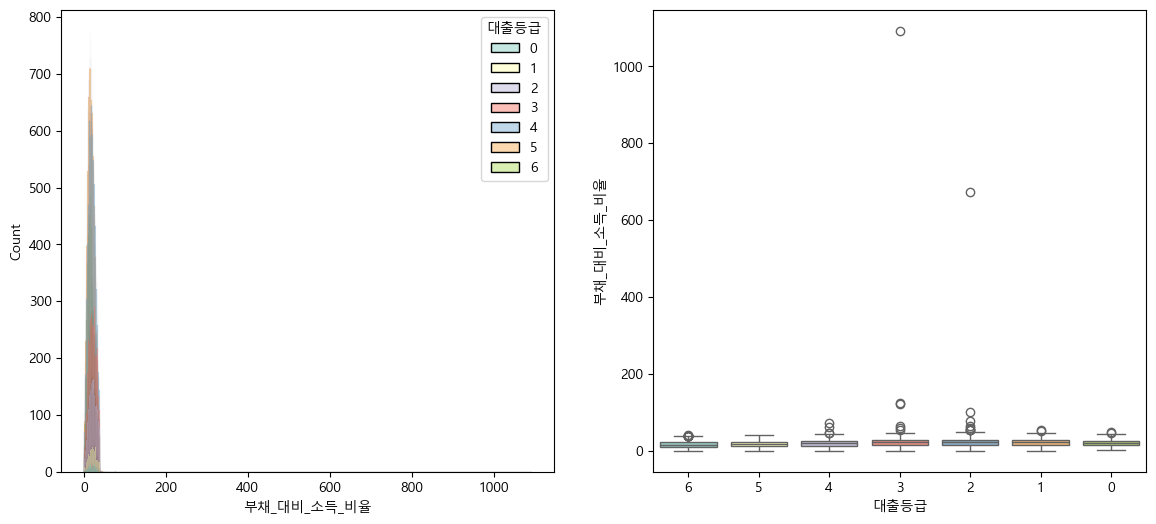

,mean,std,min,max
6,16.547850,7.558913,0.00,39.80
5,18.129529,8.191684,0.00,41.69
4,19.908835,8.788839,0.00,71.40
3,21.808465,13.166067,0.00,1092.52
2,22.248466,11.977395,0.16,672.52
1,21.853710,8.913153,0.66,54.36
0,20.691952,8.718104,0.82,47.61


C:\Users\LG\AppData\Local\Temp\ipykernel_7936\2029728365.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df3, y=col, x='대출등급', order=hue_order, ax=ax[1], palette='Set3')


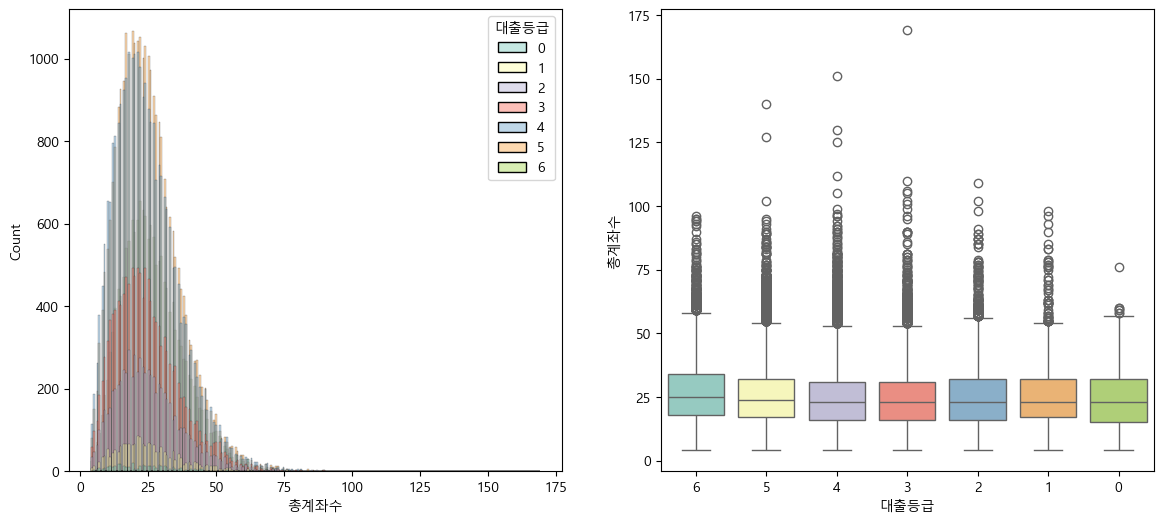

,mean,std,min,max
6,26.910684,11.788615,4.0,96.0
5,25.223375,11.765557,4.0,140.0
4,24.695243,12.195834,4.0,151.0
3,24.705107,12.357153,4.0,169.0
2,25.320642,12.522195,4.0,109.0
1,25.543501,12.950036,4.0,98.0
0,24.550000,12.482346,4.0,76.0


C:\Users\LG\AppData\Local\Temp\ipykernel_7936\2029728365.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df3, y=col, x='대출등급', order=hue_order, ax=ax[1], palette='Set3')


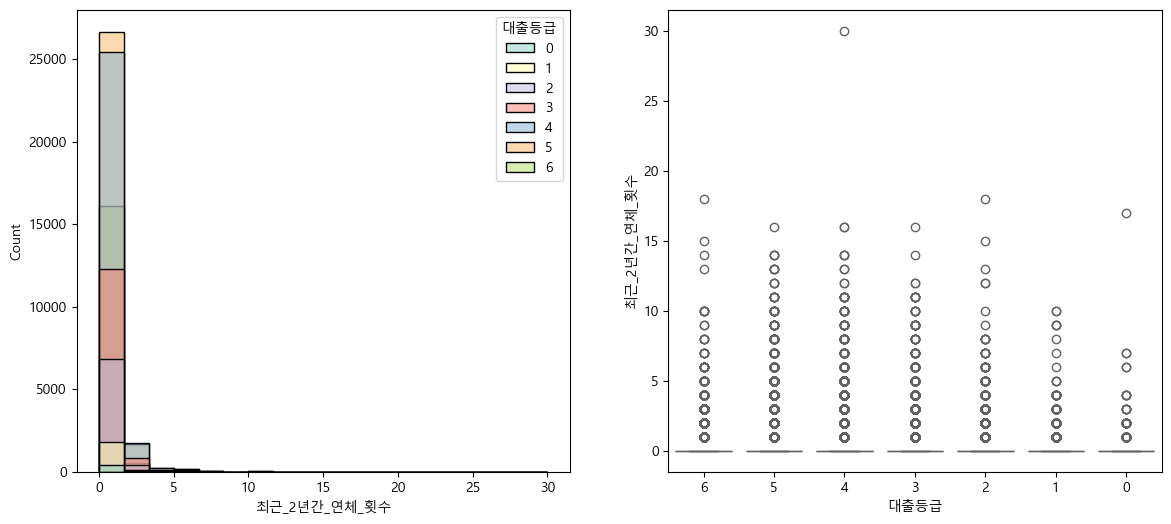

,mean,std,min,max
6,0.218698,0.704163,0.0,18.0
5,0.365409,0.947582,0.0,16.0
4,0.380240,0.966574,0.0,30.0
3,0.384379,0.970777,0.0,16.0
2,0.349334,0.914513,0.0,18.0
1,0.361822,0.914466,0.0,10.0
0,0.416667,1.239835,0.0,17.0


C:\Users\LG\AppData\Local\Temp\ipykernel_7936\2029728365.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df3, y=col, x='대출등급', order=hue_order, ax=ax[1], palette='Set3')


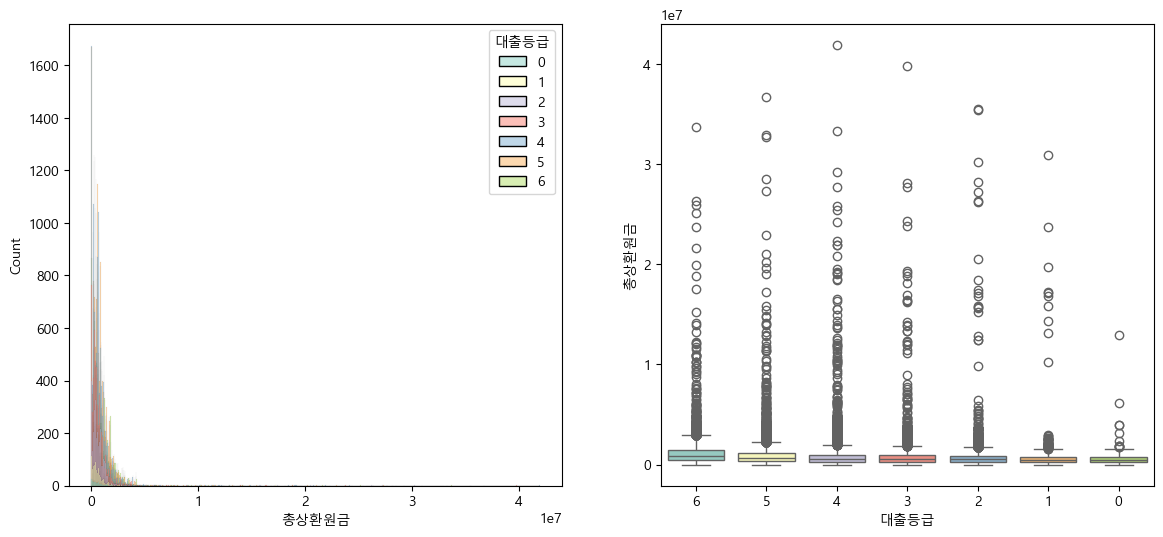

,mean,std,min,max
6,1.066966e+06,1.076776e+06,0.0,33683988.0
5,8.340144e+05,9.403085e+05,0.0,36721164.0
4,7.521276e+05,9.754031e+05,0.0,41955936.0
3,7.297173e+05,1.018910e+06,0.0,39793896.0
2,7.074507e+05,1.238723e+06,0.0,35550000.0
1,6.673177e+05,1.368616e+06,0.0,30911292.0
0,5.870190e+05,8.149610e+05,0.0,12937416.0


C:\Users\LG\AppData\Local\Temp\ipykernel_7936\2029728365.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df3, y=col, x='대출등급', order=hue_order, ax=ax[1], palette='Set3')


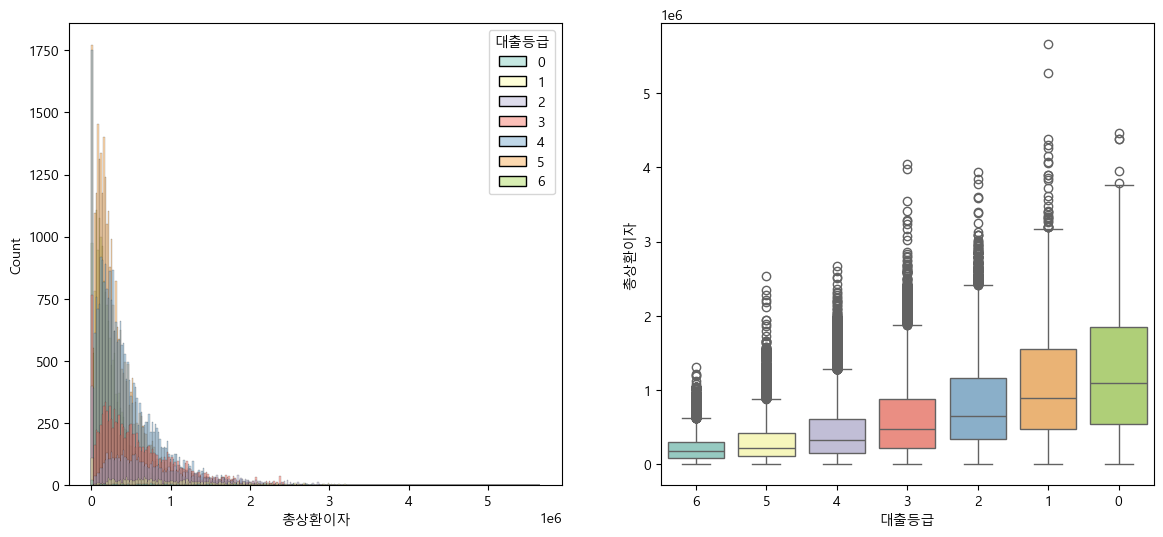

,mean,std,min,max
6,2.240085e+05,183508.609726,0.0,1315908.0
5,3.033410e+05,268912.292532,0.0,2538084.0
4,4.306869e+05,377470.042163,0.0,2671956.0
3,6.117896e+05,520056.028372,0.0,4048740.0
2,8.146975e+05,627671.231203,0.0,3942252.0
1,1.095274e+06,819704.001437,0.0,5653416.0
0,1.284655e+06,952955.115509,0.0,4464612.0


C:\Users\LG\AppData\Local\Temp\ipykernel_7936\2029728365.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df3, y=col, x='대출등급', order=hue_order, ax=ax[1], palette='Set3')


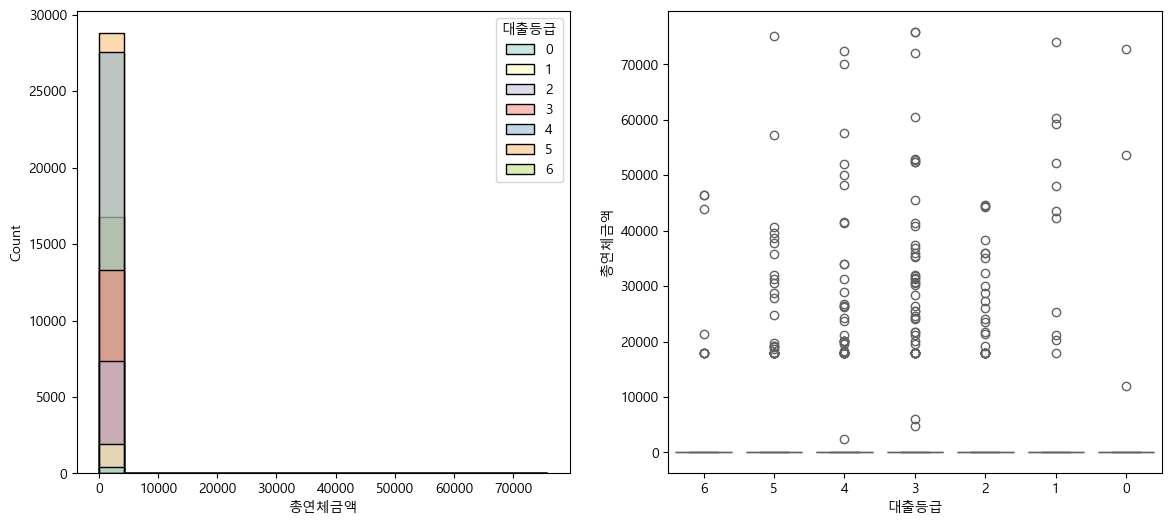

,mean,std,min,max
6,14.806105,704.850463,0.0,46536.0
5,29.441371,983.715162,0.0,75216.0
4,48.054305,1258.816194,0.0,72444.0
3,113.352104,2127.823877,0.0,75768.0
2,94.572206,1678.616326,0.0,44688.0
1,237.801433,3437.789928,0.0,74076.0
0,329.942857,4448.705070,0.0,72864.0


C:\Users\LG\AppData\Local\Temp\ipykernel_7936\2029728365.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df3, y=col, x='대출등급', order=hue_order, ax=ax[1], palette='Set3')


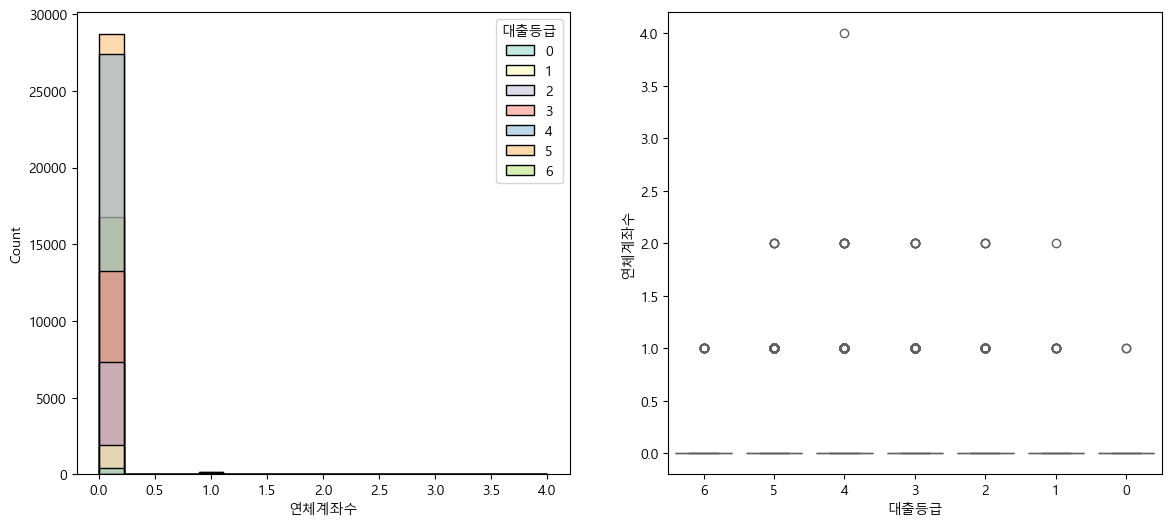

,mean,std,min,max
6,0.001133,0.033640,0.0,1.0
5,0.004789,0.071019,0.0,2.0
4,0.007892,0.094809,0.0,4.0
3,0.008462,0.096382,0.0,2.0
2,0.007615,0.091509,0.0,2.0
1,0.006653,0.087385,0.0,2.0
0,0.004762,0.068924,0.0,1.0


In [15]:
num_list = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수']
hue_order = [6,5,4,3,2,1,0]

def num_value_count(df, col):
    statistic_df = pd.DataFrame()

    for level in hue_order:
        level_df = df.loc[(df['대출등급']==level)][[col]].describe().T[['mean', 'std', 'min', 'max']]
        level_df.index = [level]
        statistic_df = pd.concat([statistic_df, level_df], axis=0)

    display(statistic_df)
    print()

for col in num_list:    
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 6))
    sns.histplot(data=train_df3, x=col, hue='대출등급', ax=ax[0], palette='Set3')
    sns.boxplot(data=train_df3, y=col, x='대출등급', order=hue_order, ax=ax[1], palette='Set3')
    plt.show()
    num_value_count(train_df3, col)

## 3. 상관관계

In [16]:
train_df2 = train_df.copy()

# A~G = 6~0
def get_grade_to_num(x):
    if x == 'A': return 6
    if x == 'B': return 5
    if x == 'C': return 4
    if x == 'D': return 3
    if x == 'E': return 2
    if x == 'F': return 1
    if x == 'G': return 0

train_df2['grade'] = train_df2['대출등급'].apply(lambda x : get_grade_to_num(x))
train_df2 = train_df2.drop(['대출등급'], axis = 1)
train_df2 = train_df2.drop(['주택소유상태'], axis = 1)
train_df2 = train_df2.drop(['대출목적'], axis = 1)
train_df2.head()

,대출금액,대출기간,근로기간,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,상환부담율,상환율,대출_대비_총상환금_비율,잔여상환금_대비_연체금액_비율,연체계좌비율,주택소유여부,grade
0,12480000,36,6.0,72000000,18.90,15,0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0,4
1,14400000,60,10.0,130800000,22.33,21,0,373572,234060.0,0.0,0.0,0.016254,0.025943,0.042197,0.0,0.0,0,5
2,12000000,36,5.0,96000000,8.60,14,0,928644,151944.0,0.0,0.0,0.012662,0.077387,0.090049,0.0,0.0,0,6
3,14400000,36,8.0,132000000,15.09,15,0,325824,153108.0,0.0,0.0,0.010632,0.022627,0.033259,0.0,0.0,0,4
4,18000000,60,NaN,71736000,25.39,19,0,228540,148956.0,0.0,0.0,0.008275,0.012697,0.020972,0.0,0.0,0,5


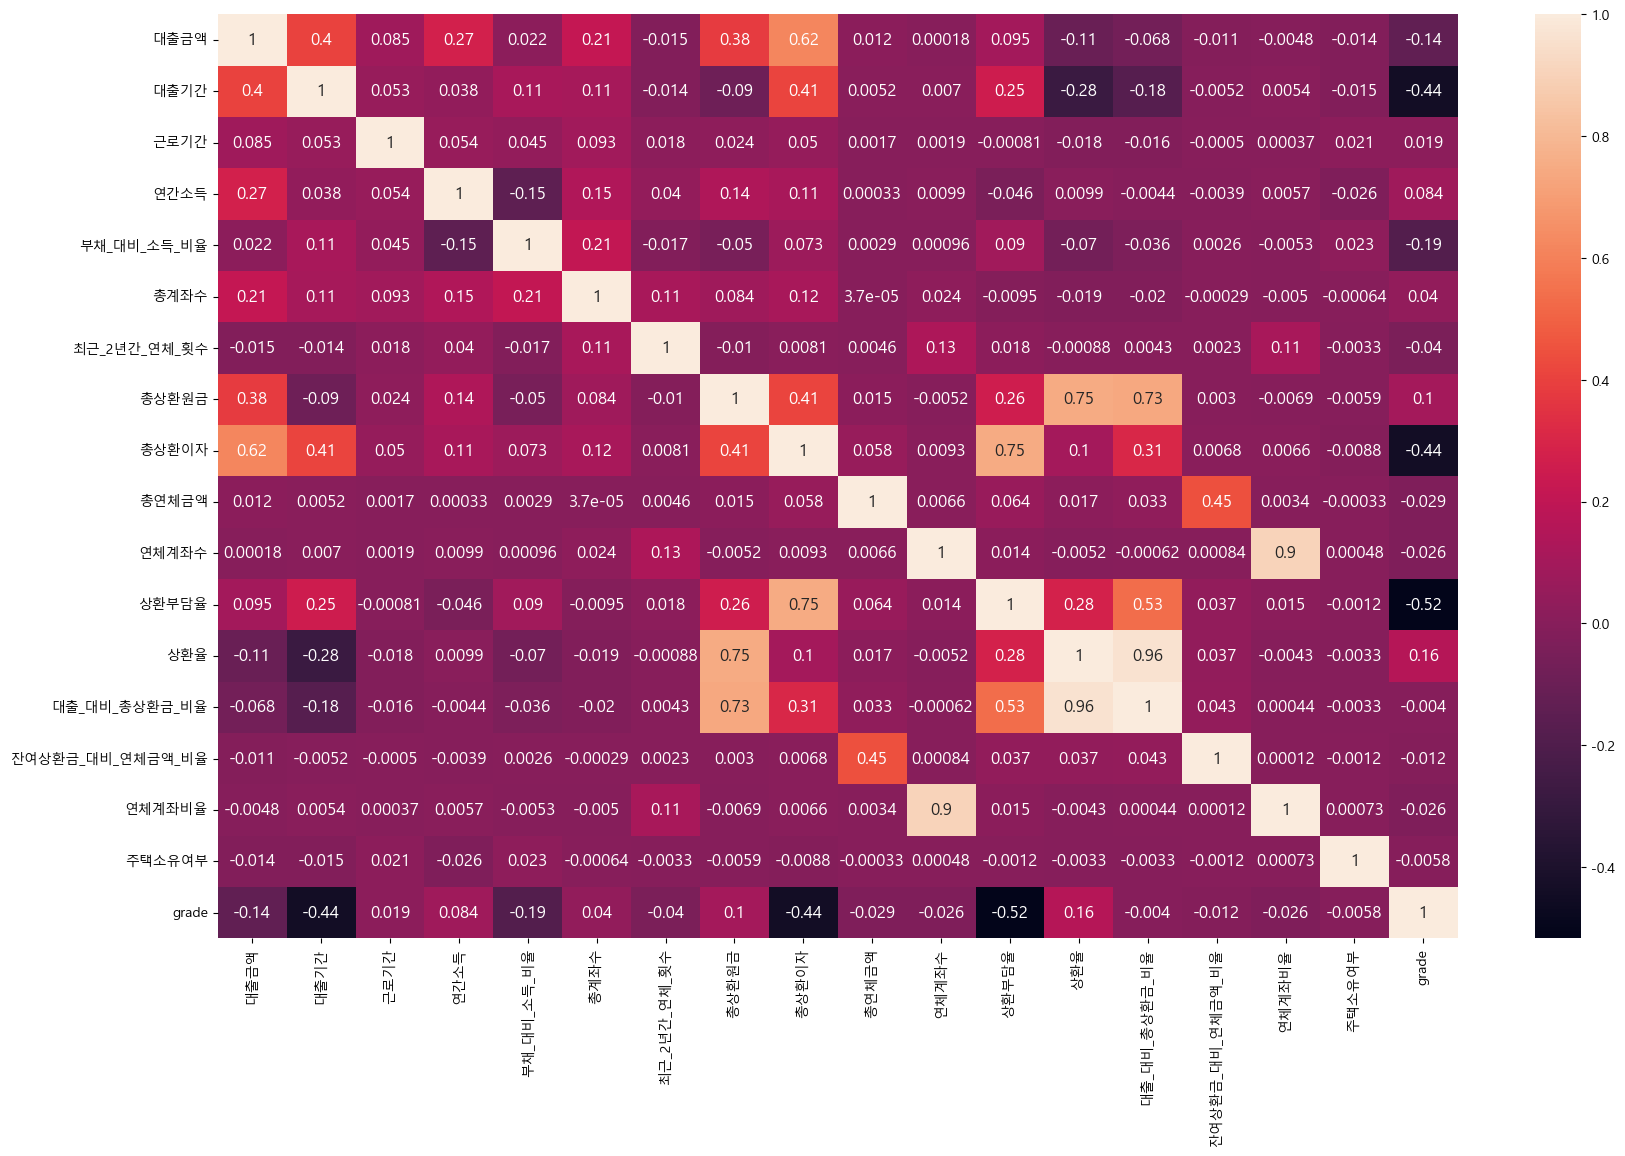

In [17]:
plt.rcParams["figure.figsize"] = (20,12)
sns.heatmap(train_df2.corr(), annot = True, annot_kws={"size": 12})
plt.rc('axes', labelsize=36) 
plt.show()

## 5. 가설검정 

[가설 목적] 대출 은행의 매출 증대 (+이자, -연체금액)

: 대출 잠재 고객 세그먼트 정의  
: 발굴되지 않은 대출 가능자 찾기  
: 대출도 많이 받으면서 대출상환도 잘 할 것 같은 대출등급 세그먼트 찾기

- 대출금액이 높을수록 대출등급이 높을 것이다.
    - 그만한 돈을 빌릴 만한 자산이 있을 가능성이 있기 때문
    - 부채_대비_소득_비율(=부채/소득)이 낮은 사람이 대출등급이 높을 것이다.
- 대출금액 대비 총상환금(총상환원금+총상환이자)이 높을수록 대출등급이 높을 것이다.
    - 대출금액 대비 총상환원금 비율 알아보기
    - 대출금액 대비 총상환이자 비율 알아보기
- 총연체금액 / (대출금액 - 총상환원금)이 낮을수록 대출등급이 높을 것이다.

#### (1) 대출금액이 높을수록 대출등급이 높을 것이다.
> 대출등급이 낮을수록 대출금액이 높아짐

C:\Users\LG\AppData\Local\Temp\ipykernel_7936\1614027019.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df3, x='대출등급', y='대출금액', order=hue_order, ax=ax[1], palette='Set3')


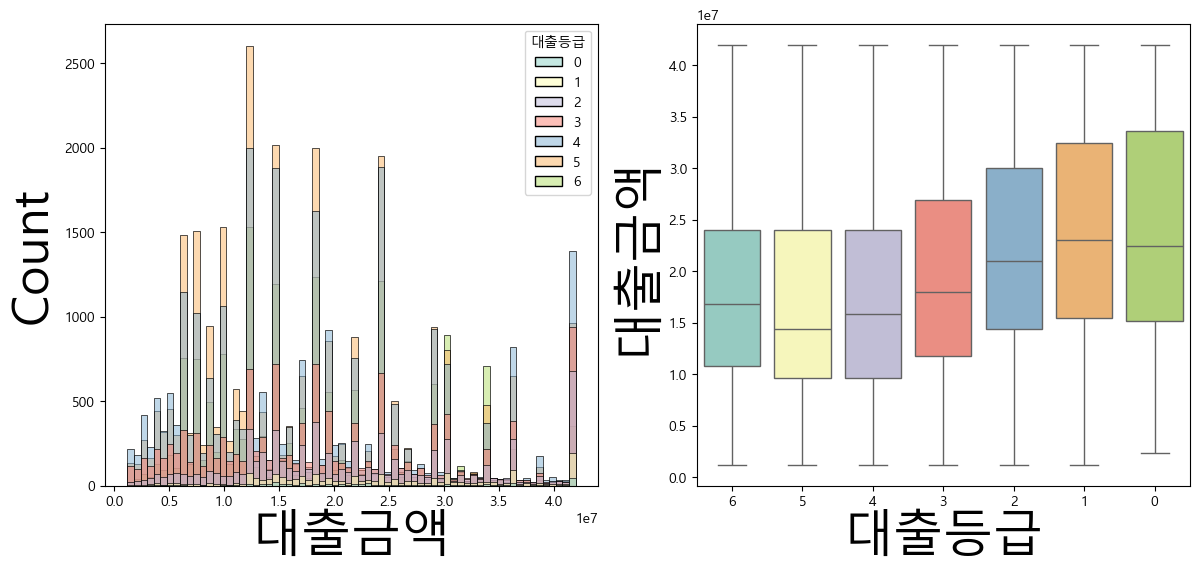

,mean,std,min,max
6,1.790579e+07,9.294000e+06,1200000.0,42000000.0
5,1.686808e+07,9.772310e+06,1200000.0,42000000.0
4,1.789053e+07,1.052497e+07,1200000.0,42000000.0
3,1.953331e+07,1.097276e+07,1200000.0,42000000.0
2,2.232013e+07,1.077465e+07,1200000.0,42000000.0
1,2.400517e+07,1.061245e+07,1200000.0,42000000.0
0,2.402079e+07,1.080393e+07,2310000.0,42000000.0


In [18]:
hue_order=[6,5,4,3,2,1,0]

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 6))

sns.histplot(data=train_df3, x='대출금액', hue='대출등급', ax=ax[0], palette='Set3')
sns.boxplot(data=train_df3, x='대출등급', y='대출금액', order=hue_order, ax=ax[1], palette='Set3')
plt.show()
num_value_count(train_df3, '대출금액')

#### (2) 대출금액 대비 총상환금이 높을수록 대출등급이 높을 것이다.

> 각 등급 별 총 개수에 비례해서 대출_대비_총상환금_비율에 따른 대출등급 분포도 나타나고 있다고 봐야할 것 같다.   
> 딱히 연관까지는 아니지만,
> C(4), D(3) 등급의 사람들이 상환을 잘 하긴 하는 것 같다.  
> 더 알아보고 싶었는데,, 여러가지 저의 기술부족으로 하다가 일단 패스

사용할 컬럼
- 총상환금 = 총상환원금 + 총상환이자
- 대출_대비_총상환금_비율 = 총상환금 / 총상환이자

C:\Users\LG\AppData\Local\Temp\ipykernel_7936\3148416566.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df3, y='대출_대비_총상환금_비율', x='대출등급', order=hue_order, ax=ax[1], palette='Set3')


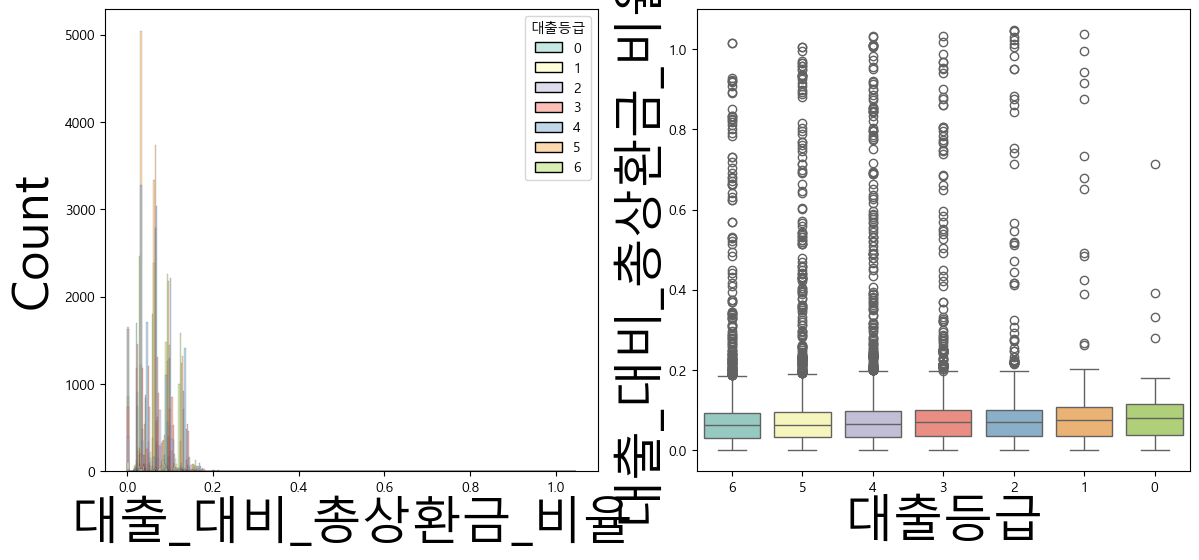

,mean,std,min,max
6,0.072540,0.052922,0.0,1.016026
5,0.069159,0.051288,0.0,1.005453
4,0.069173,0.054601,0.0,1.031824
3,0.071992,0.056577,0.0,1.031826
2,0.070645,0.059444,0.0,1.046424
1,0.074641,0.066403,0.0,1.038026
0,0.077859,0.055614,0.0,0.713584


In [19]:
hue_order=[6,5,4,3,2,1,0]

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 6))

sns.histplot(data=train_df3, x='대출_대비_총상환금_비율', hue='대출등급', ax=ax[0], palette='Set3')
sns.boxplot(data=train_df3, y='대출_대비_총상환금_비율', x='대출등급', order=hue_order, ax=ax[1], palette='Set3')
plt.show()
num_value_count(train_df3, '대출_대비_총상환금_비율')

In [20]:
# 대출금액보다 총상환금이 더 많은 고객은 대체로 몇 등급이지?
# 총상환율이 1.0을 초과한 사람_등급 카운트
grade_over_1 = pd.DataFrame(train_df3[train_df3['대출_대비_총상환금_비율'] > 1.0]['대출등급'])
grade_over_1['카운트값'] = 1
grade_over_1.groupby('대출등급').count()

,카운트값
대출등급,
1,1
2,7
3,2
4,8
5,2
6,2


In [21]:
# 만약 등급이 A등급(6)이라면 전체 A등급자 중에 총상환율이 1.0을 넘는 사람은 몇 명인지 비율을 구할 수 있지 않을까?
train_df3[train_df3['대출등급']==6]['대출등급'].count()

16772

In [25]:
grade_list = []
for i in range(7):
    grade_cnt = train_df3[train_df3['대출등급']==i]['대출등급'].count()
    grade_list.append(grade_cnt)
grade_list

[420, 1954, 7354, 13354, 27622, 28817, 16772]

In [28]:
# 총상환율이 1.0을 초과한 사람_등급 비율(반복문 써보려고 했지만 ,, 해결못함)
payoff_range = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
for over in payoff_range:
    for i in range(7):
        grade_over_payoff = pd.DataFrame(train_df3[train_df3['대출_대비_총상환금_비율'] > over]['대출등급'])
        grade_over_payoff['카운트값'] = 1
        grade_over_payoff_count = grade_over_payoff.groupby('대출등급').count
        grade_over_payoff_total_count = train_df3[train_df3['대출등급'] == i].groupby('대출등급').count
        grade_over_payoff_ratio = grade_over_payoff_count/grade_over_payoff_total_count
    grade_over_payoff_ratio

ValueError: DataFrame constructor not properly called!

In [ ]:
# 총상환율이 0.9를 초과한 사람_등급 카운트
grade_over_09 = pd.DataFrame(train_df3[train_df3['대출_대비_총상환금_비율'] > 0.9]['대출등급'])
grade_over_09['카운트값'] = 1
grade_over_09.groupby('대출등급').count()

,카운트값
대출등급,
1,4
2,10
3,9
4,15
5,18
6,7


In [ ]:
# 총상환율이 0.8를 초과한 사람_등급 카운트
grade_over_08 = pd.DataFrame(train_df3[train_df3['대출_대비_총상환금_비율'] > 0.8]['대출등급'])
grade_over_08['카운트값'] = 1
grade_over_08.groupby('대출등급').count()

,카운트값
대출등급,
1,5
2,14
3,16
4,31
5,24
6,17


In [ ]:
# 총상환율이 0.7를 초과한 사람_등급 카운트
grade_over_ratio = pd.DataFrame(train_df3[train_df3['대출_대비_총상환금_비율'] > 0.7]['대출등급'])
grade_over_ratio['카운트값'] = 1
payoff_count[payoff] = pd.DataFrame(grade_over_ratio.groupby('대출등급').count())
payoff_count

,0
대출등급,
0,1
1,6
2,17
3,24
4,40
5,34
6,24


In [30]:
# 총상환율 별 대출등급 분포
payoff_ratio = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
payoff_list = []

for payoff in payoff_ratio:
    payoff_count = pd.DataFrame()
    grade_over_ratio = pd.DataFrame(train_df3[train_df3['대출_대비_총상환금_비율'] > payoff]['대출등급'])
    grade_over_ratio['카운트값'] = 1
    payoff_count[payoff] = grade_over_ratio.groupby('대출등급').count()
    pd.DataFrame(payoff_list.append(payoff_count[payoff]))
    #payoff_count_df = pd.DataFrame(payoff_list.append(payoff_count[payoff]))
    #payoff_count = pd.concat(payoff_count, payoff_count_df, axis=1)

payoff_list

[대출등급
 1    1
 2    7
 3    2
 4    8
 5    2
 6    2
 Name: 1, dtype: int64,
 대출등급
 1     4
 2    10
 3     9
 4    15
 5    18
 6     7
 Name: 0.9, dtype: int64,
 대출등급
 1     5
 2    14
 3    16
 4    31
 5    24
 6    17
 Name: 0.8, dtype: int64,
 대출등급
 0     1
 1     6
 2    17
 3    24
 4    40
 5    34
 6    24
 Name: 0.7, dtype: int64,
 대출등급
 0     1
 1     8
 2    17
 3    28
 4    51
 5    42
 6    35
 Name: 0.6, dtype: int64,
 대출등급
 0     1
 1     8
 2    22
 3    36
 4    67
 5    57
 6    42
 Name: 0.5, dtype: int64,
 대출등급
 0     1
 1    11
 2    27
 3    41
 4    80
 5    75
 6    49
 Name: 0.4, dtype: int64,
 대출등급
 0      3
 1     12
 2     29
 3     50
 4    104
 5     95
 6     68
 Name: 0.3, dtype: int64,
 대출등급
 0      4
 1     15
 2     53
 3    122
 4    187
 5    155
 6    119
 Name: 0.2, dtype: int64,
 대출등급
 0     107
 1     521
 2    2117
 3    3339
 4    5759
 5    4546
 6    3212
 Name: 0.1, dtype: int64,
 대출등급
 0      396
 1     1845
 2     6959
 3    12621
 4 

#### + 상환부담율(총상환이자/대출금액)과 대출등급의 연관성

C:\Users\LG\AppData\Local\Temp\ipykernel_13052\3533325220.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df3, y='상환부담율', x='대출등급', order=hue_order, ax=ax[1], palette='Set3')


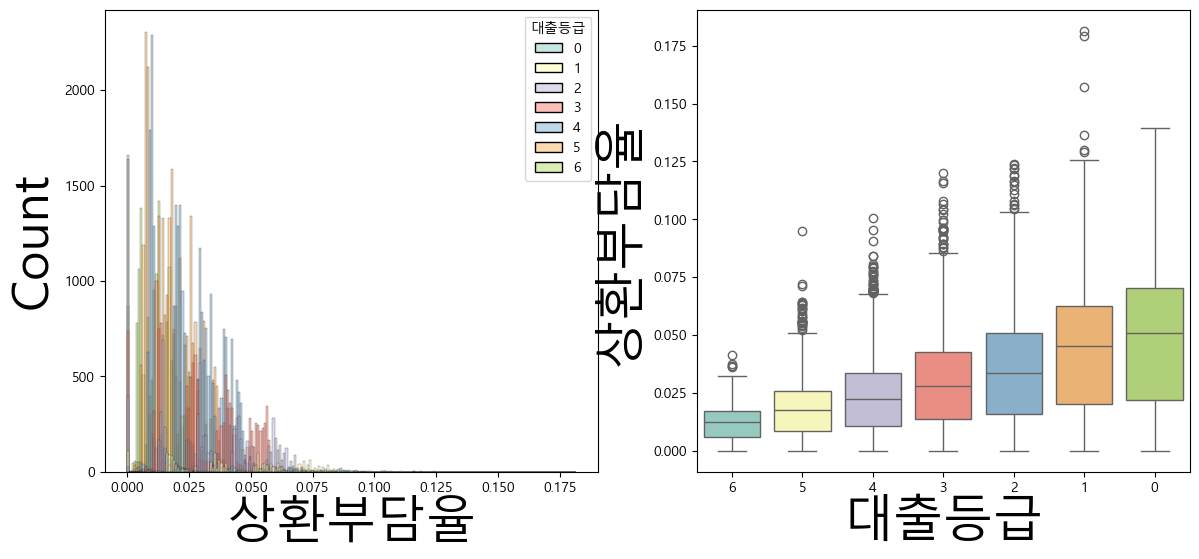

,mean,std,min,max
6,0.012414,0.006792,0.0,0.041269
5,0.017697,0.009932,0.0,0.094911
4,0.023875,0.013314,0.0,0.100353
3,0.031217,0.017358,0.0,0.120203
2,0.036467,0.019927,0.0,0.123920
1,0.045236,0.025082,0.0,0.181466
0,0.052082,0.028765,0.0,0.139385


In [ ]:
hue_order=[6,5,4,3,2,1,0]

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 6))

sns.histplot(data=train_df3, x='상환부담율', hue='대출등급', ax=ax[0], palette='Set3')
sns.boxplot(data=train_df3, y='상환부담율', x='대출등급', order=hue_order, ax=ax[1], palette='Set3')
plt.show()
num_value_count(train_df3, '상환부담율')

#### (3) 잔여상환금_대비_연체금액 비율이 낮을수록 대출등급이 높을 것이다.

> 잔여상환금_대비_연체금액 비율이 낮다고 해서 대출등급이 높은 것도 아니고, 높다고 해서 대출등급이 낮은 것도 아니었다,,ㅎ  
> 오히려 각 등급 별 총 개수에 비례해서 잔여상환금 연체금액 비율에 따른 대출등급 분포도 나타나고 있다고 봐야할 것 같다. 

사용할 컬럼
- 잔여상환금 = 대출금액 - 총상환원금
- 잔여상환금_대비_연체금액_비율 = 총연체금액 / 잔여상환금

C:\Users\LG\AppData\Local\Temp\ipykernel_13052\314420830.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df3, y='잔여상환금_대비_연체금액_비율', x='대출등급', order=hue_order, ax=ax[1], palette='Set3')


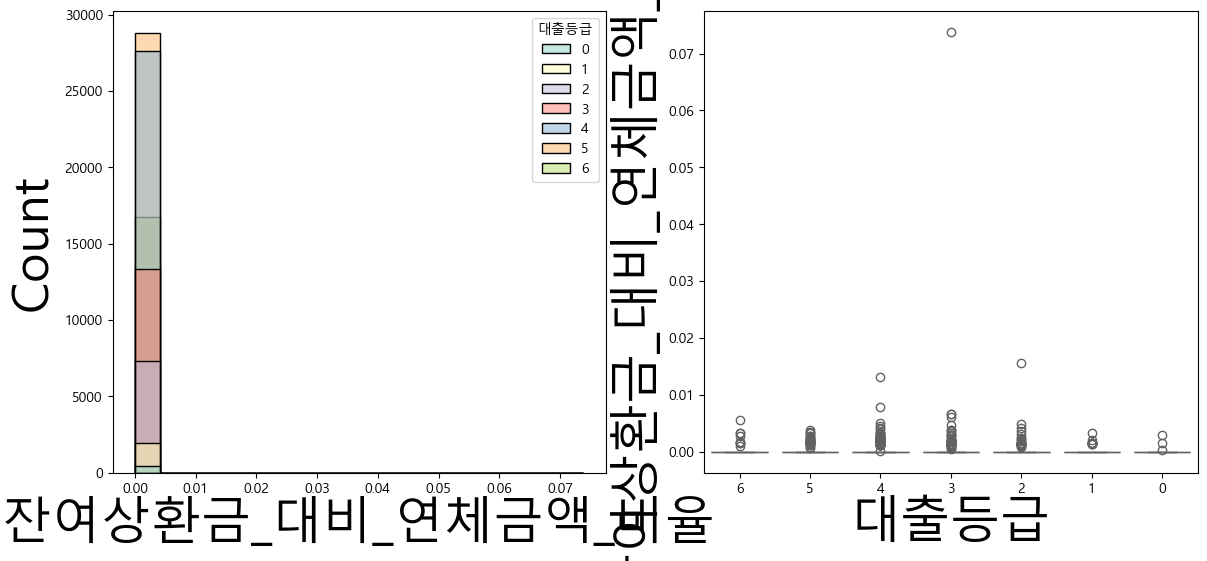

,mean,std,min,max
6,0.000001,0.000065,0.0,0.005562
5,0.000002,0.000071,0.0,0.003883
4,0.000005,0.000135,0.0,0.013108
3,0.000013,0.000657,0.0,0.073844
2,0.000009,0.000221,0.0,0.015652
1,0.000009,0.000131,0.0,0.003213
0,0.000012,0.000165,0.0,0.002984


In [ ]:
hue_order=[6,5,4,3,2,1,0]

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 6))

sns.histplot(data=train_df3, x='잔여상환금_대비_연체금액_비율', hue='대출등급', ax=ax[0], palette='Set3')
sns.boxplot(data=train_df3, y='잔여상환금_대비_연체금액_비율', x='대출등급', order=hue_order, ax=ax[1], palette='Set3')
plt.show()
num_value_count(train_df3, '잔여상환금_대비_연체금액_비율')

In [35]:
# 대출등급 3에 유독 튀는 값이 있는데 확인 ㄱㄱ
train_df3[train_df3['잔여상환금_대비_연체금액_비율'] > 0.07]
# 이 비율이 0.07부터 0.02까지 내려갈 때까지도 이 한 사람밖에 없었음

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,상환부담율,상환율,대출_대비_총상환금_비율,잔여상환금_대비_연체금액_비율,연체계좌비율,주택소유여부
45697,1920000,36,NaN,RENT,24868800,22.64,26,휴가,0,944976,199344.0,72000.0,0.0,3,0.103825,0.492175,0.596,0.073844,0.0,0


In [41]:
# 잔여상환금_대비_연체금액_비율이 0.01을 넘는 사람
train_df3[train_df3['잔여상환금_대비_연체금액_비율'] > 0.01]

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,상환부담율,상환율,대출_대비_총상환금_비율,잔여상환금_대비_연체금액_비율,연체계좌비율,주택소유여부
45697,1920000,36,NaN,RENT,24868800,22.64,26,휴가,0,944976,199344.0,72000.0,0.0,3,0.103825,0.492175,0.596000,0.073844,0.0,0
51446,1200000,36,10.0,MORTGAGE,84000000,15.46,28,휴가,1,49968,37344.0,18000.0,0.0,2,0.031120,0.041640,0.072760,0.015652,0.0,0
80884,1440000,36,3.0,MORTGAGE,69600000,21.17,53,부채 통합,0,66816,26988.0,18000.0,0.0,4,0.018742,0.046400,0.065142,0.013108,0.0,0


In [43]:
# 잔여상환금_대비_연체금액_비율이 0.005는 넘고 0.01보다 작은 사람
train_df3[(train_df3['잔여상환금_대비_연체금액_비율'] > 0.005) & (train_df3['잔여상환금_대비_연체금액_비율'] <= 0.01)]

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,상환부담율,상환율,대출_대비_총상환금_비율,잔여상환금_대비_연체금액_비율,연체계좌비율,주택소유여부
10696,3840000,36,1.0,RENT,57600000,14.80,25,주택 개선,0,263964,120336.0,18000.0,0.0,4,0.031337,0.068741,0.100078,0.005034,0.0,0
15423,3600000,36,10.0,MORTGAGE,72000000,10.76,28,부채 통합,0,363876,76632.0,18000.0,0.0,6,0.021287,0.101077,0.122363,0.005562,0.0,0
43254,2400000,36,9.0,MORTGAGE,60000000,34.35,35,기타,3,109452,50964.0,18000.0,0.0,4,0.021235,0.045605,0.066840,0.007858,0.0,0
69068,3000000,36,3.0,MORTGAGE,72000000,28.02,26,주택 개선,4,260412,168060.0,18000.0,0.0,3,0.056020,0.086804,0.142824,0.006570,0.0,0
71853,3000000,36,10.0,MORTGAGE,62400000,27.16,14,부채 통합,0,303576,238536.0,18000.0,0.0,3,0.079512,0.101192,0.180704,0.006676,0.0,0
79026,6030000,36,0.0,RENT,72000000,9.72,15,의료,0,195192,328464.0,36000.0,0.0,3,0.054472,0.032370,0.086842,0.006170,0.0,0


## 6. 모델

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#### (1) RF

- 대출금액, 대출_대비_총상환금_비율, 잔여상환금_대비_연체금액_비율

In [46]:
model_rf = RandomForestClassifier()

X_features = ['대출금액', '대출_대비_총상환금_비율', '잔여상환금_대비_연체금액_비율']

x = train_df3[X_features]
y = train_df3['대출등급']

model_rf.fit(x, y)
y_rf_pred = model_rf.predict(x)

def get_score(model_name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted') #각 클래스에 대한 F1 스코어를 계산하고, 클래스별 샘플 수에 따라 가중 평균을 계산하여 전체 F1 스코어를 얻음
    print(model_name, ')', 'acc 스코어: ', acc, ',', 'f1 스코어: ', f1)

get_score('rf', y, y_rf_pred)

rf ) acc 스코어:  0.9399748683704943 , f1 스코어:  0.9400938002035624


- 대출_대비_총상환금_비율, 잔여상환금_대비_연체금액_비율

In [49]:
model_rf = RandomForestClassifier()

X_features = ['대출_대비_총상환금_비율', '잔여상환금_대비_연체금액_비율']

x = train_df3[X_features]
y = train_df3['대출등급']

model_rf.fit(x, y)
y_rf_pred = model_rf.predict(x)

def get_score(model_name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted') #각 클래스에 대한 F1 스코어를 계산하고, 클래스별 샘플 수에 따라 가중 평균을 계산하여 전체 F1 스코어를 얻음
    print(model_name, ')', 'acc 스코어: ', acc, ',', 'f1 스코어: ', f1)

get_score('rf', y, y_rf_pred)

rf ) acc 스코어:  0.940556426739223 , f1 스코어:  0.941099971154002


- 대출_대비_총상환금_비율

In [50]:
model_rf = RandomForestClassifier()

X_features = ['대출_대비_총상환금_비율']

x = train_df3[X_features]
y = train_df3['대출등급']

model_rf.fit(x, y)
y_rf_pred = model_rf.predict(x)

def get_score(model_name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted') #각 클래스에 대한 F1 스코어를 계산하고, 클래스별 샘플 수에 따라 가중 평균을 계산하여 전체 F1 스코어를 얻음
    print(model_name, ')', 'acc 스코어: ', acc, ',', 'f1 스코어: ', f1)

get_score('rf', y, y_rf_pred)

rf ) acc 스코어:  0.95361033512301 , f1 스코어:  0.9542342727120553


#### (2) XGB, LGBM

In [47]:
model_xgb = XGBClassifier(random_state=42)
model_lgb = LGBMClassifier(random_state=42)

model_xgb.fit(x, y)
model_lgb.fit(x, y)

y_xgb_pred = model_xgb.predict(x)
y_lgb_pred = model_lgb.predict(x)

get_score('xgb', y, y_xgb_pred)
get_score('lgb', y, y_lgb_pred)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points in the train set: 96293, number of used features: 3
[LightGBM] [Info] Start training from score -5.434896
[LightGBM] [Info] Start training from score -3.897517
[LightGBM] [Info] Start training from score -2.572151
[LightGBM] [Info] Start training from score -1.975580
[LightGBM] [Info] Start training from score -1.248783
[LightGBM] [Info] Start training from score -1.206430
[LightGBM] [Info] Start training from score -1.747685
xgb ) acc 스코어:  0.7594840746471706 , f1 스코어:  0.757332233063169
lgb ) acc 스코어:  0.7549146874643017 , f1 스코어:  0.7531730630024807


### (3) Logistic Regression

In [55]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression()

X_features = ['대출_대비_총상환금_비율']

x = train_df3[X_features]
y = train_df3['대출등급']

model_lr.fit(x, y)
y_lr_pred = model_lr.predict(x)

def get_score(model_name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted') #각 클래스에 대한 F1 스코어를 계산하고, 클래스별 샘플 수에 따라 가중 평균을 계산하여 전체 F1 스코어를 얻음
    print(model_name, ')', 'acc 스코어: ', acc, ',', 'f1 스코어: ', f1)

get_score('lr', y, y_lr_pred)

lr ) acc 스코어:  0.29912870094399385 , f1 스코어:  0.13863298154525205


> 아주 거지같은 수치가 나와버렸다..!